In [112]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import Input, Dense
from keras.models import Model
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
import utils

rcParams['figure.figsize'] = 14, 8

In [113]:
cam_data = pd.read_pickle('../traffic_data/raw_station_segment_data.pkl')
bus_data = pd.read_pickle('../traffic_data/raw_bus_data.pkl')
bus_data_coords = pd.read_pickle('../traffic_data/raw_data_with_corrigated_coords.pkl')
cam_data_month = pd.read_parquet('../traffic_data/raw_station_segment_data_2021-12-01_2022-01-01.parquet')

In [114]:
bus_data_coords = utils.preprocess_bus_data(bus_data_coords)
bus_data = utils.preprocess_bus_data(bus_data)
bus_data = utils.day_filter(bus_data,10)

In [115]:
scaler = MinMaxScaler()
train_data = utils.preprocess_cam_data(cam_data_month)['avg_speed'].values.reshape(-1,1)
train_data = pd.DataFrame(scaler.fit_transform(train_data))

In [116]:
test_data = cam_data['avg_speed'].values.reshape(-1,1)
test_data = pd.DataFrame(scaler.fit_transform(test_data))

In [117]:
def create_model(input_dimension):
    input_layer = Input(shape=(input_dimension, ))
    encoder = Dense(input_dimension, activation="tanh")(input_layer)
    encoder = Dense(int(input_dimension * 2), activation="relu")(encoder)
    decoder = Dense(int(input_dimension * 2), activation='tanh')(encoder)
    decoder = Dense(input_dimension, activation='relu')(decoder)
    return Model(inputs=input_layer, outputs=decoder)

In [118]:
autoencoder = create_model(train_data.shape[1])

autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])
autoencoder.fit(train_data, train_data,
                    epochs=100,
                    batch_size=30,
                    shuffle=True,
                    verbose=1)

Epoch 1/100
220/220 [==============================] - 1s 2ms/step - loss: 0.1339 - accuracy: 0.2146
Epoch 2/100
220/220 [==============================] - 0s 2ms/step - loss: 0.1339 - accuracy: 0.2146
Epoch 3/100
220/220 [==============================] - 0s 2ms/step - loss: 0.1339 - accuracy: 0.2146
Epoch 4/100
220/220 [==============================] - 0s 2ms/step - loss: 0.1339 - accuracy: 0.2146
Epoch 5/100
220/220 [==============================] - 0s 2ms/step - loss: 0.1339 - accuracy: 0.2146
Epoch 6/100
220/220 [==============================] - 0s 2ms/step - loss: 0.1339 - accuracy: 0.2146
Epoch 7/100
220/220 [==============================] - 0s 2ms/step - loss: 0.1339 - accuracy: 0.2146
Epoch 8/100
220/220 [==============================] - 0s 2ms/step - loss: 0.1339 - accuracy: 0.2146
Epoch 9/100
220/220 [==============================] - 0s 2ms/step - loss: 0.1339 - accuracy: 0.2146
Epoch 10/100
220/220 [==============================] - 0s 2ms/step - loss: 0.1339 - accura

In [119]:
prediction = autoencoder.predict(test_data)
measurement_error = np.mean(np.power(test_data - prediction, 2), axis=1)

295/295 [==============================] - 1s 2ms/step


In [120]:
threshold = 0.0065
normal_data = cam_data[cam_data.index.isin(np.where(measurement_error < threshold)[0])]
outliers = cam_data[cam_data.index.isin(np.where(measurement_error > threshold)[0])]

In [121]:
len(outliers)

969

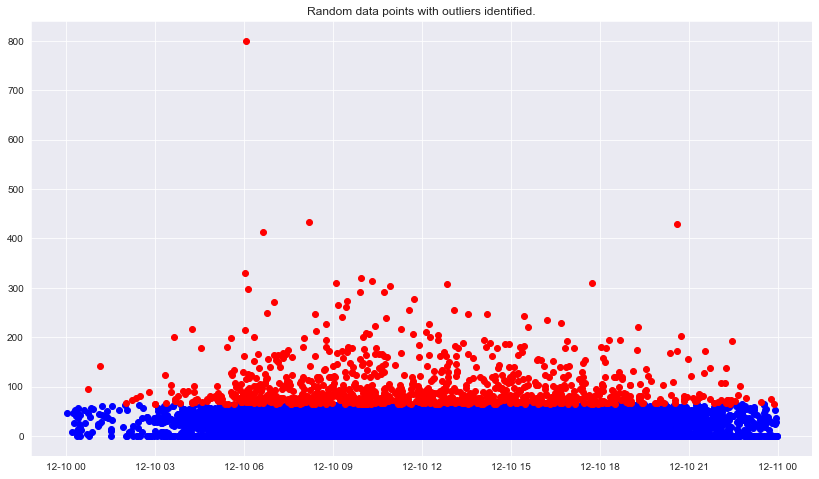

In [122]:
plt.scatter(x=normal_data['timestamp'],y=normal_data['avg_speed'],color='b')
plt.scatter(x=outliers['timestamp'],y=outliers['avg_speed'],color='r')
plt.title("Random data points with outliers identified.")
plt.show()

<AxesSubplot:xlabel='timestamp'>

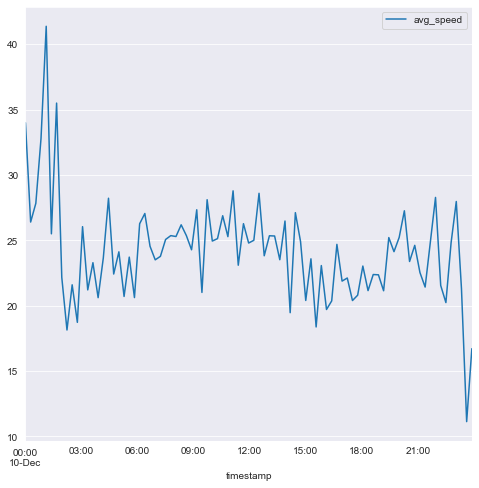

In [123]:
utils.create_speed_curve_plot_data(normal_data,'avg_speed',1000).plot.line(x='timestamp',y='avg_speed',figsize=(8,8))

In [124]:
plot_bus = utils.create_speed_curve_plot_data(bus_data,'velocity',1000)
plot_camera = utils.create_speed_curve_plot_data(normal_data,'avg_speed',1000)
plot_camera_before = utils.create_speed_curve_plot_data(cam_data,'avg_speed',1000)
plot_bus = plot_bus[plot_bus['velocity'] != 0]
plot_camera = plot_camera[plot_camera['avg_speed'] != 0]
plot_camera_before = plot_camera_before[plot_camera_before['avg_speed'] != 0]

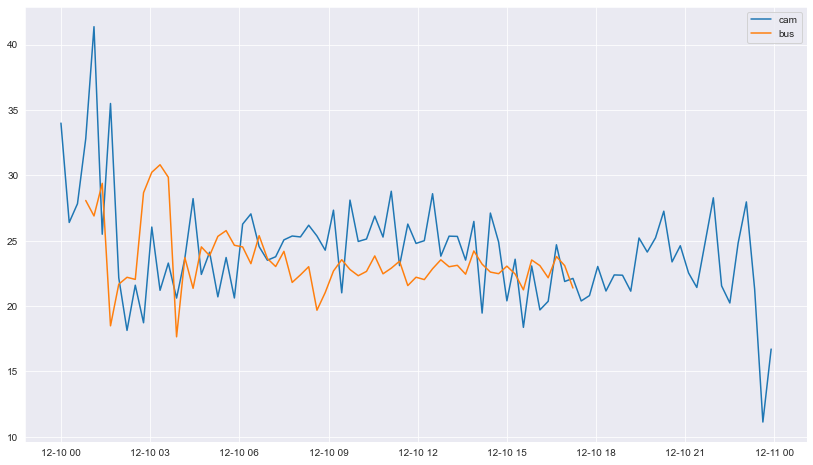

In [125]:
utils.two_line_plot(plot_bus,plot_camera)

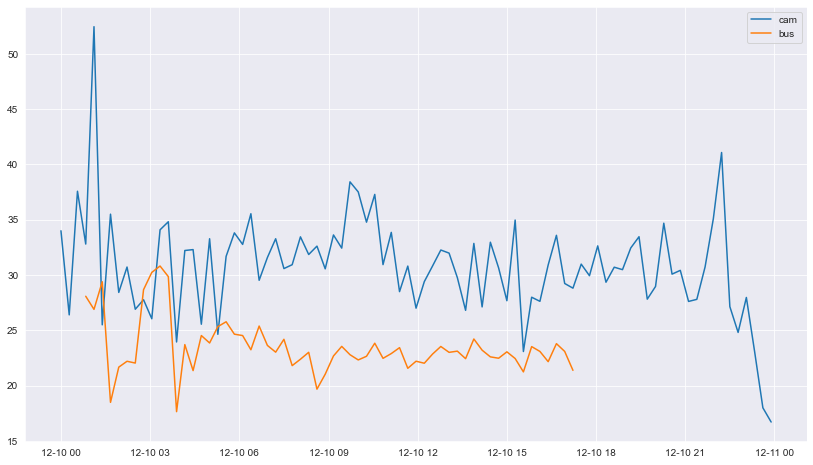

In [126]:
utils.two_line_plot(plot_bus,plot_camera_before)